<a href="https://colab.research.google.com/github/AkmalRendiansyah/Holti-Health/blob/main/machine-learning/Chili_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile


# Load Data

In [2]:
# Download the dataset
file_id = '16g1OQ7OPdRmby3_gKg1OXHEEWkJtLGS2'

output_file = 'Dataset.zip'

# Generate the download link
download_link = f'https://drive.google.com/uc?id={file_id}'

# Download the file
!gdown $download_link -O $output_file

Downloading...
From (original): https://drive.google.com/uc?id=16g1OQ7OPdRmby3_gKg1OXHEEWkJtLGS2
From (redirected): https://drive.google.com/uc?id=16g1OQ7OPdRmby3_gKg1OXHEEWkJtLGS2&confirm=t&uuid=ab171a41-4deb-45b3-9e8f-773ae455eacd
To: /content/Dataset.zip
100% 197M/197M [00:03<00:00, 49.8MB/s]


In [3]:
!unzip -q /content/Dataset.zip

In [4]:
train_data_dir = 'Dataset/Train'
validation_data_dir = 'Dataset/Valid'
test_data_dir = 'Dataset/Test'

sorted_labels = [
    'Bercak Daun', 'Busuk Buah Antraknosa', 'Kutu Daun','Sehat', 'Thrips',
    'Virus Kuning'
]

# train directories
train_directories = {label: os.path.join(train_data_dir, label) for label in sorted_labels}

# validation directories
validation_directories = {label: os.path.join(validation_data_dir, label) for label in sorted_labels}

# test directories
test_directories = {label: os.path.join(test_data_dir, label) for label in sorted_labels}

for label in sorted_labels:
    print('Total training', label, 'images:', len(os.listdir(train_directories[label])))

for label in sorted_labels:
    print('Total validation', label, 'images:', len(os.listdir(validation_directories[label])))

Total training Bercak Daun images: 80
Total training Busuk Buah Antraknosa images: 80
Total training Kutu Daun images: 80
Total training Sehat images: 80
Total training Thrips images: 80
Total training Virus Kuning images: 80
Total validation Bercak Daun images: 10
Total validation Busuk Buah Antraknosa images: 10
Total validation Kutu Daun images: 10
Total validation Sehat images: 10
Total validation Thrips images: 10
Total validation Virus Kuning images: 10


# Preprocess Data

In [5]:
train_data_dir = 'Dataset/Train'
validation_data_dir = 'Dataset/Valid'

# Membuat ImageDataGenerator untuk augmentasi data dan preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk data training dan validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)



Found 480 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


# Create Model Using Transfer Learning

In [6]:
# Memuat model MobileNetV2 yang sudah pre-trained
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer-layer awal
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer untuk klasifikasi
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,575,878 (13.64 MB)

 Trainable params: 1,317,894 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = Callback()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1,
    callbacks= callbacks
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4995 - loss: 1.5522 - val_accuracy: 0.8333 - val_loss: 0.5164
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7569 - loss: 0.6331 - val_accuracy: 0.8500 - val_loss: 0.5411
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8574 - loss: 0.3970 - val_accuracy: 0.7667 - val_loss: 0.6823
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8801 - loss: 0.3524 - val_accuracy: 0.8833 - val_loss: 0.4817
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9273 - loss: 0.2166 - val_accuracy: 0.8667 - val_loss: 0.5558
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8805 - loss: 0.3153 - val_accuracy: 0.8833 - val_loss: 0.5697
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9032 - loss: 0.3226 - val_accuracy: 0.8667 - val_loss: 0.5869
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9038 - loss: 0.2456 - val_accuracy: 0.8833 - val_loss: 0.5289
Epo

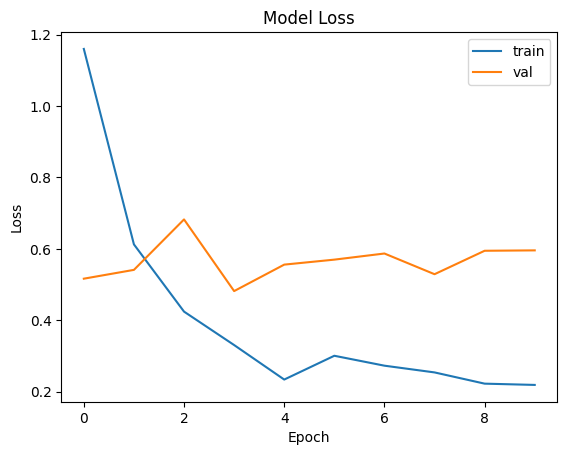

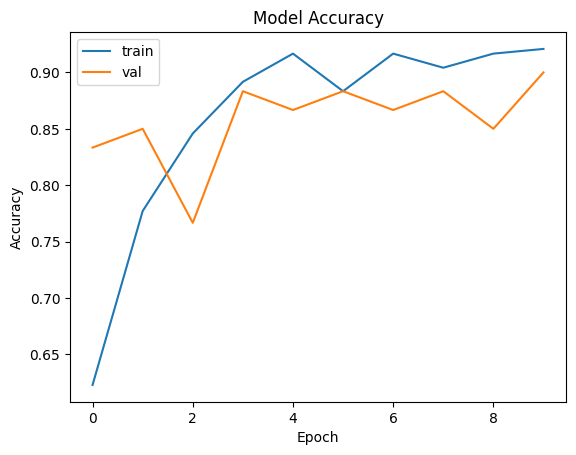

In [9]:
import matplotlib.pyplot as plt

# Visualisasi loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Visualisasi accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
# Predictions from validation folder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array

for label in sorted_labels:
  folder = validation_directories[label]

  for path_file in os.listdir(folder):
    # Get value from image
    path_file = os.path.join(folder, path_file)
    img = image.load_img(path_file, target_size=(224, 224))
    x = img_to_array(img)
    x = x/255
    x = np.expand_dims(x, axis=0)

    # Predict the image label
    images = np.vstack([x])
    classes = model.predict(images, batch_size=31)

    # Take the class index with the highest probability
    predicted_class_index = classes.argmax()

    # Convert class indices to label
    predicted_label = sorted_labels[predicted_class_index]

    print("Label:", label, "Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Label: Bercak Daun Predicted Label: Virus Kuning
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Label: Bercak Daun Predicted Label: Bercak Daun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Label: Busuk Buah Antraknosa Predicted Label: Busuk Buah Antraknosa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


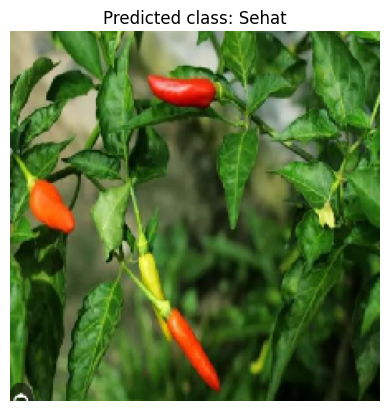

In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Fungsi preprocess input sesuai dengan MobileNetV2
def preprocess_input(x):
    return tf.keras.applications.mobilenet_v2.preprocess_input(x)
# Fungsi untuk memprediksi kelas gambar tunggal
def predict_image(img_path):
  # Load gambar dan preprocess
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # Lakukan prediksi
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  # Ambil kelas dengan probabilitas tertinggi
  predicted_class = np.argmax(classes)

  # Daftar nama kelas
  class_names = ['Bercak Daun', 'Busuk Buah Antraknosa','Kutu Daun','Sehat','Thrips','Virus Kuning']

  # Tampilkan gambar dan hasil prediksi
  plt.imshow(img)
  plt.axis('off')
  plt.title("Predicted class: {}".format(class_names[predicted_class]))
  plt.show()

# Contoh penggunaan
img_path = '/content/t.PNG'
predict_image(img_path)

In [11]:
model.evaluate(validation_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step - accuracy: 0.9017 - loss: 0.5108


[0.5956529378890991, 0.8999999761581421]

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite  model
with open('Chili_Disease_DetectionV2.2.tflite', 'wb') as f:
  f.write(tflite_model)


Saved artifact at '/tmp/tmpbau_0e3v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136846599582496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416909712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416907072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416909360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416911648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416919392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416918336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416914816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416910240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136846416919568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1368464169

In [17]:
model.save('Chili_Disease_DetectionV2.2.h5')